# 1. Setup and Installations


In [ ]:
!pip install optuna

In [ ]:
!pip install catBoost
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import mean_squared_error


In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

# 2. EDA

Most missing fuel_type values were just electric cars.

In [ ]:
num_cols = list(train.select_dtypes(include=[np.float64, np.int64]))
cat_cols = list(train.select_dtypes(include="object"))

<Axes: >

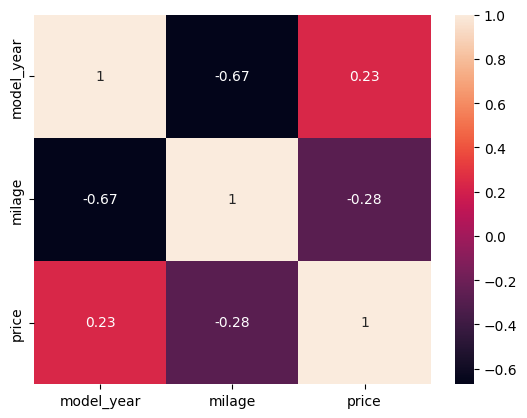

In [ ]:
sns.heatmap(train.corr(numeric_only=True), annot=True)

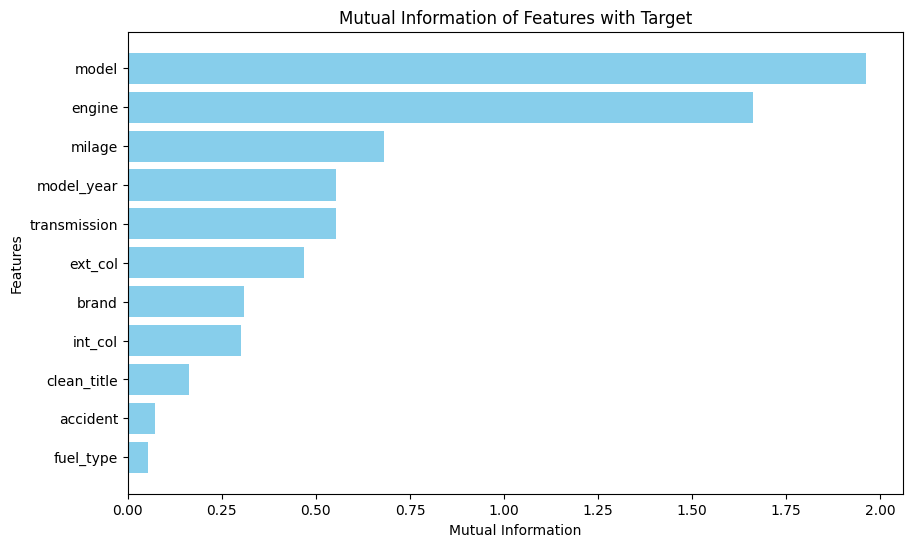

In [ ]:
from sklearn.feature_selection import mutual_info_classif

columns = train.columns[:-1]
# Target column
target_column = 'price'

# Sample the data if necessary (optional)
# df_sampled = train.sample(n=10000, random_state=42)  # Uncomment if you want to sample the data
df_sampled = train  # Use the entire dataset

# Calculate mutual information
X = df_sampled[columns]
y = df_sampled[target_column]

# Function to calculate mutual information for a single column
def calculate_mi(column):
    if X[column].dtype == 'object':
        X_encoded = X[[column]].apply(lambda col: col.astype('category').cat.codes)
        mi = mutual_info_classif(X_encoded, y, discrete_features=True)
        return mi.sum()
    else:
        mi = mutual_info_classif(X[[column]], y, discrete_features=False)
        return mi[0]

# Calculate mutual information for each column
mi_scores = {col: calculate_mi(col) for col in columns}

# Print the dictionary of mutual information values
mi_df = pd.DataFrame(list(mi_scores.items()), columns=['Feature', 'Mutual Information'])

# Sort the DataFrame by mutual information
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information of Features with Target')
plt.gca().invert_yaxis()
plt.show()

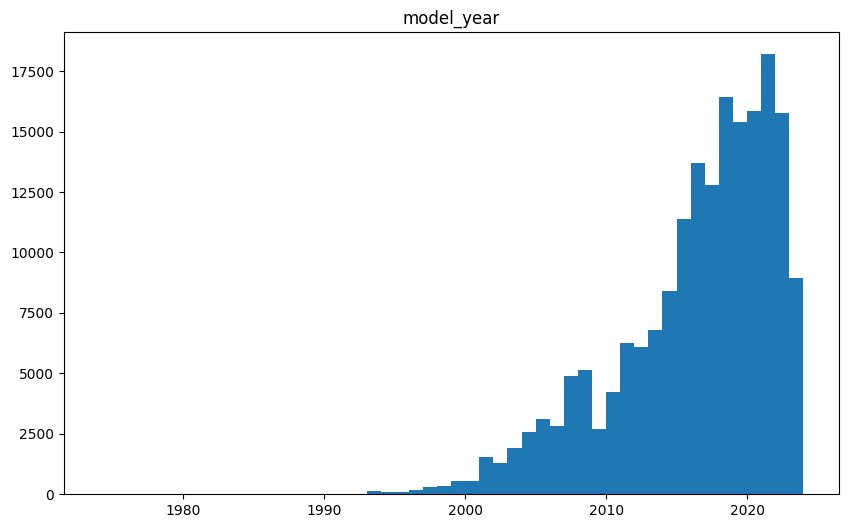

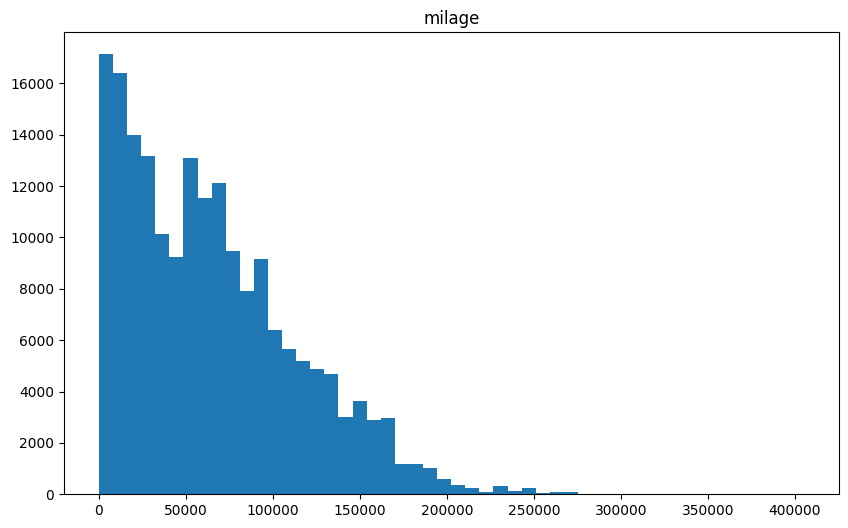

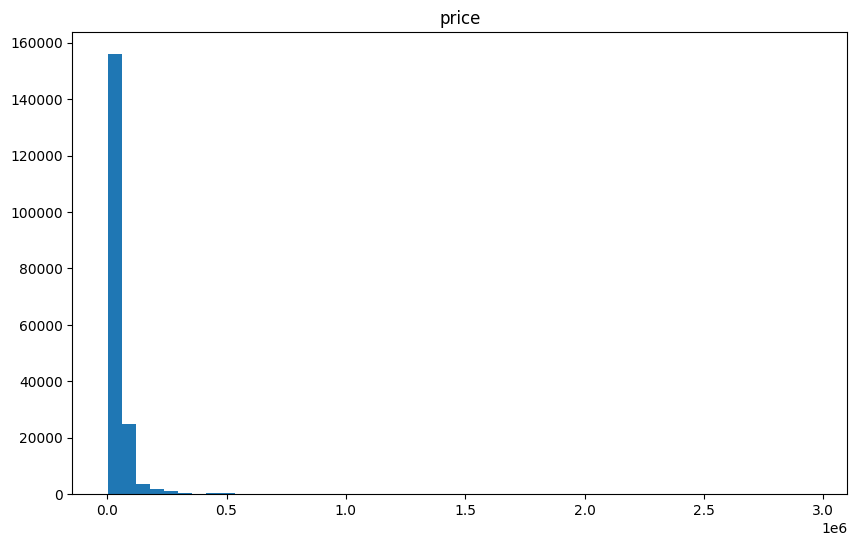

In [ ]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    plt.title(col)
    plt.hist(train[col], bins=50)

In [ ]:
len(train["model"].unique())

1897

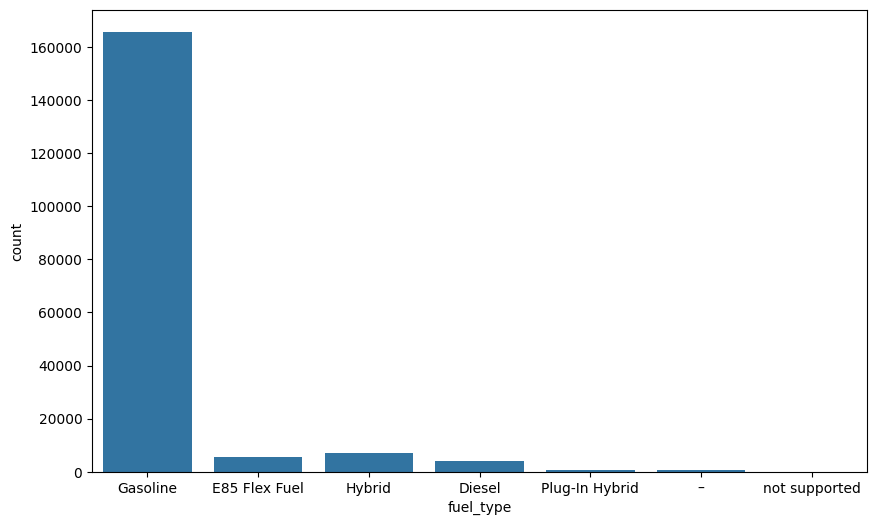

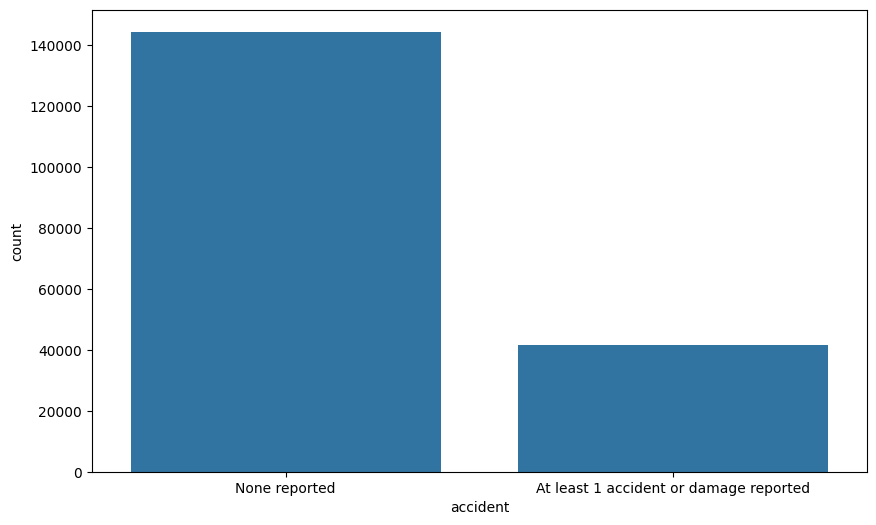

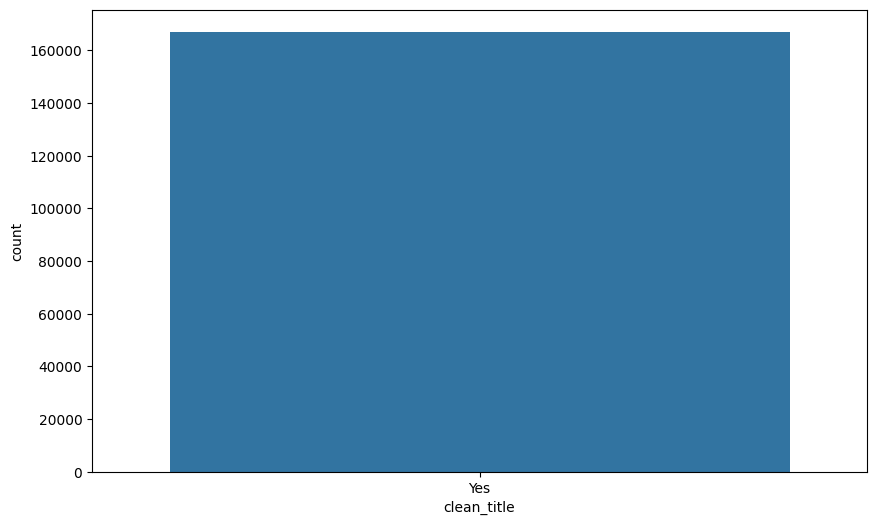

In [ ]:
small_cat_cols = [col for col in cat_cols if len(train[col].unique())< 15]

for col in small_cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train, x=col)

# 3. Feature Engineering

In [ ]:
for col in train.columns:
    if train[col].isna().sum() > 0:
        train[f'{col}_missing'] = train[col].isnull().astype(int)

for col in test.columns:
    if test[col].isna().sum() > 0:
        test[f'{col}_missing'] = test[col].isnull().astype(int)

In [ ]:
train.isna().sum(), test.isna().sum()

(brand                      0
 model                      0
 model_year                 0
 milage                     0
 fuel_type               5083
 engine                     0
 transmission               0
 ext_col                    0
 int_col                    0
 accident                2452
 clean_title            21419
 price                      0
 fuel_type_missing          0
 accident_missing           0
 clean_title_missing        0
 dtype: int64,
 brand                      0
 model                      0
 model_year                 0
 milage                     0
 fuel_type               3383
 engine                     0
 transmission               0
 ext_col                    0
 int_col                    0
 accident                1632
 clean_title            14239
 fuel_type_missing          0
 accident_missing           0
 clean_title_missing        0
 dtype: int64)

In [ ]:
engine_splits = [x.split() for x in train["engine"].values]
test_splits = [x.split() for x in test["engine"].values]

In [ ]:
idxs_electric = []
idxs_gasoline = []
idxs_hybrid = []
idxs_diesel = []
idxs_flex = []

for split in engine_splits:
    if ("Electric" in split) or ("Battery" in split):
        idxs_electric.append(True)
    else:
        idxs_electric.append(False)

for split in engine_splits:
    if "Gasoline" in split:
        idxs_gasoline.append(True)
    else:
        idxs_gasoline.append(False)

for split in engine_splits:
    if "Hybrid" in split:
        idxs_hybrid.append(True)
    else:
        idxs_hybrid.append(False)

for split in engine_splits:
    if "Flex" in split:
        idxs_flex.append(True)
    else:
        idxs_flex.append(False)

for split in engine_splits:
    if "Diesel" in split:
        idxs_diesel.append(True)
    else:
        idxs_diesel.append(False)

idxs_electric_test = []
idxs_gasoline_test = []
idxs_hybrid_test = []
idxs_diesel_test = []
idxs_flex_test = []

for split in test_splits:
    if ("Electric" in split) or ("Battery" in split):
        idxs_electric_test.append(True)
    else:
        idxs_electric_test.append(False)

for split in test_splits:
    if "Gasoline" in split:
        idxs_gasoline_test.append(True)
    else:
        idxs_gasoline_test.append(False)

for split in test_splits:
    if "Hybrid" in split:
        idxs_hybrid_test.append(True)
    else:
        idxs_hybrid_test.append(False)

for split in test_splits:
    if "Flex" in split:
        idxs_flex_test.append(True)
    else:
        idxs_flex_test.append(False)

for split in test_splits:
    if "Diesel" in split:
        idxs_diesel_test.append(True)
    else:
        idxs_diesel_test.append(False)

In [ ]:
train.loc[train["brand"] == "Tesla", "fuel_type"] = "Electric"
train.loc[train["brand"] == "Rivian", "fuel_type"] = "Electric"

test.loc[train["brand"] == "Tesla", "fuel_type"] = "Electric"
test.loc[train["brand"] == "Rivian", "fuel_type"] = "Electric"

In [ ]:
train.loc[idxs_electric & train["fuel_type"].isna(), "fuel_type"] = "Electric"
train.loc[idxs_gasoline & train["fuel_type"].isna(), "fuel_type"] = "Gasoline"
train.loc[idxs_hybrid & train["fuel_type"].isna(), "fuel_type"] = "Hybrid"
train.loc[idxs_diesel & train["fuel_type"].isna(), "fuel_type"] = "Diesel"
train.loc[idxs_flex & train["fuel_type"].isna(), "fuel_type"] = "Flex"

test.loc[idxs_electric_test & test["fuel_type"].isna(), "fuel_type"] = "Electric"
test.loc[idxs_gasoline_test & test["fuel_type"].isna(), "fuel_type"] = "Gasoline"
test.loc[idxs_hybrid_test & test["fuel_type"].isna(), "fuel_type"] = "Hybrid"
test.loc[idxs_diesel_test & test["fuel_type"].isna(), "fuel_type"] = "Diesel"
test.loc[idxs_flex_test & test["fuel_type"].isna(), "fuel_type"] = "Flex"

/tmp/ipython-input-305383186.py:1: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train.loc[idxs_electric & train["fuel_type"].isna(), "fuel_type"] = "Electric"
/tmp/ipython-input-305383186.py:2: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train.loc[idxs_gasoline & train["fuel_type"].isna(), "fuel_type"] = "Gasoline"
/tmp/ipython-input-305383186.py:3: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train.loc[idxs_hybrid & train

In [ ]:
train.loc[train["fuel_type"].isna(), "fuel_type"] = "Electric"

test.loc[test["fuel_type"].isna(), "fuel_type"] = "Electric"

In [ ]:
test.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,1632


In [ ]:
# cant infer from other features
train.loc[train["accident"].isna(), "accident"] = "None reported"

test.loc[test["accident"].isna(), "accident"] = "None reported"


In [ ]:
train.clean_title.value_counts()

,count
clean_title,
Yes,167114


In [ ]:
train.loc[train["clean_title"].isna(), "clean_title"] = "No"
test.loc[test["clean_title"].isna(), "clean_title"] = "No"

In [ ]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_missing,accident_missing,clean_title_missing
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0


In [ ]:
import re

pattern = re.compile(r'^\d+(\.\d+)?HP$')

hp_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

hp_col_train = []

for hp in hp_list_train:
    if len(hp) == 1:
        hp_col_train.append(np.float64(hp[0].split('.')[0]))
    else:
        hp_col_train.append(np.nan)

hp_col_train = np.array(hp_col_train)
train["horsepower"] = hp_col_train

hp_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

hp_col_test = []

for hp in hp_list_test:
    if len(hp) == 1:
        hp_col_test.append(np.float64(hp[0].split('.')[0]))
    else:
        hp_col_test.append(np.nan)

hp_col_test = np.array(hp_col_test)
test["horsepower"] = hp_col_test

In [ ]:
# liters is missing

pattern = re.compile(r'^\d+(\.\d+)?L$')

# Process train data
l_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

l_col_train = []

for l in l_list_train:
    if len(l) == 1:
        l_col_train.append(np.float64(l[0][:-1]))  # Remove the 'L' and convert to float
    else:
        l_col_train.append(np.nan)

l_col_train = np.array(l_col_train)
train["engine_liters"] = l_col_train

# Process test data
l_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

l_col_test = []

for l in l_list_test:
    if len(l) == 1:
        l_col_test.append(np.float64(l[0][:-1]))  # Remove the 'L' and convert to float
    else:
        l_col_test.append(np.nan)

l_col_test = np.array(l_col_test)
test["engine_liters"] = l_col_test

In [ ]:
import re
import numpy as np

# Updated pattern to match 'V' followed by a number or just a single number
pattern = re.compile(r'^(V\d+|\d+)$')

# Extracting horsepower from training data
hp_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

hp_col_train = []

for hp in hp_list_train:
    if len(hp) == 1:
        hp_col_train.append(np.float64(hp[0].split('V')[-1]))
    else:
        hp_col_train.append(np.nan)

hp_col_train = np.array(hp_col_train)
train["cylinders"] = hp_col_train

# Extracting horsepower from test data
hp_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

hp_col_test = []

for hp in hp_list_test:
    if len(hp) == 1:
        hp_col_test.append(np.float64(hp[0].split('V')[-1]))
    else:
        hp_col_test.append(np.nan)

hp_col_test = np.array(hp_col_test)
test["cylinders"] = hp_col_test

In [ ]:
train.head(20)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_missing,accident_missing,clean_title_missing,horsepower,engine_liters,cylinders
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,172.0,1.6,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,252.0,3.9,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,320.0,5.3,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,420.0,5.0,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,208.0,2.0,4.0
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,0,0,0,252.0,2.0,4.0
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,0,0,0,333.0,3.0,6.0
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,0,0,0,355.0,5.3,8.0
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,0,0,0,NaN,2.7,6.0
9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,0,0,0,425.0,3.0,6.0


In [ ]:
train.loc[train["fuel_type"] == "Diesel", "engine"].sample(10)

,engine
151536,400.0HP 6.7L Straight 6 Cylinder Engine Diesel...
85454,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel
82512,440.0HP 6.7L 8 Cylinder Engine Diesel Fuel
138497,440.0HP 6.7L 8 Cylinder Engine Diesel Fuel
75410,325.0HP 6.0L 8 Cylinder Engine Diesel Fuel
106075,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel
100534,475.0HP 6.7L 8 Cylinder Engine Diesel Fuel
162169,445.0HP 6.6L 8 Cylinder Engine Diesel Fuel
86256,211.0HP 2.0L 4 Cylinder Engine Diesel Fuel
35281,335.0HP 6.6L 8 Cylinder Engine Diesel Fuel


In [ ]:
turbo_col = []

for split in engine_splits:
    if 'Turbo' in split:
        turbo_col.append(1)
    else:
        turbo_col.append(0)

turbo_col = np.array(turbo_col)
train["turbo"] = turbo_col

turbo_col = []

for split in test_splits:
    if 'Turbo' in split:
        turbo_col.append(1)
    else:
        turbo_col.append(0)

turbo_col = np.array(turbo_col)
test["turbo"] = turbo_col

In [ ]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_missing,accident_missing,clean_title_missing,horsepower,engine_liters,cylinders,turbo
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,172.0,1.6,4.0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,252.0,3.9,8.0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,320.0,5.3,8.0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,420.0,5.0,8.0,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,208.0,2.0,4.0,0


<Axes: xlabel='brand'>

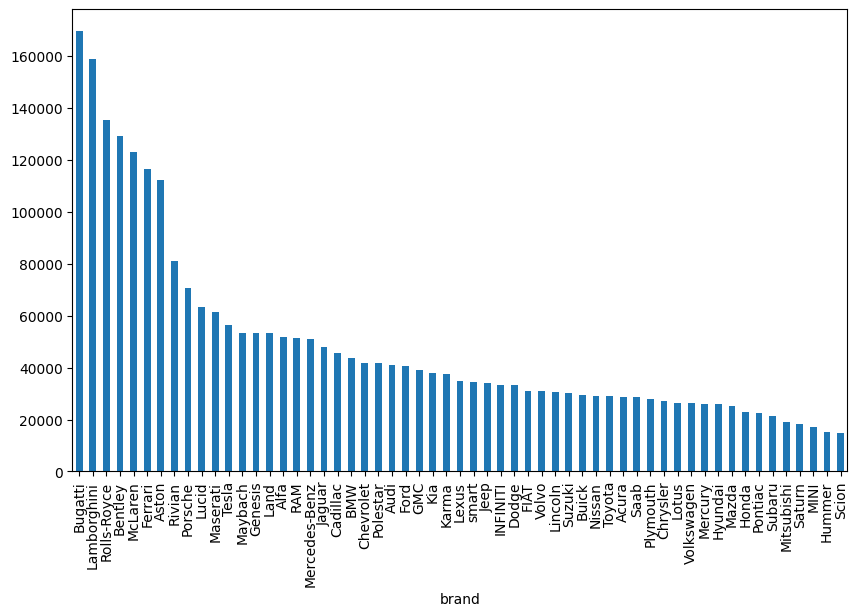

In [ ]:
plt.figure(figsize=(10, 6))
train.groupby("brand")["price"].mean().sort_values(ascending=False).plot(kind="bar")

In [ ]:
luxury_brands = ["Bugatti", "Lamborghini", 'Rolls-Royce', "Bentley", "McLaren", "Ferrari", "Aston"]

In [ ]:
luxury_col = []

for val in train["brand"]:
    if val in luxury_brands:
        luxury_col.append(1)
    else:
        luxury_col.append(0)

train["luxury_car"] = luxury_col

luxury_col = []

for val in test["brand"]:
    if val in luxury_brands:
        luxury_col.append(1)
    else:
        luxury_col.append(0)
test["luxury_car"] = luxury_col

In [ ]:
for col in train.columns:
    if train[col].isna().sum() > 0:
        train[f'{col}_missing'] = train[col].isnull().astype(int)

for col in test.columns:
    if test[col].isna().sum() > 0:
        test[f'{col}_missing'] = test[col].isnull().astype(int)

In [ ]:
train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,accident_missing,clean_title_missing,horsepower,engine_liters,cylinders,turbo,luxury_car,horsepower_missing,engine_liters_missing,cylinders_missing
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,0,0,172.0,1.6,4.0,0,0,0,0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,...,0,0,252.0,3.9,8.0,0,0,0,0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,0,0,320.0,5.3,8.0,0,0,0,0,0


In [ ]:
print(train.columns)

missing_cols = ["fuel_type_missing", "accident_missing", "clean_title_missing", "horsepower_missing", "engine_liters_missing", "cylinders_missing"]

train['missing_count'] = train[missing_cols].sum(axis=1)
test['missing_count'] = test[missing_cols].sum(axis=1)

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'fuel_type_missing', 'accident_missing', 'clean_title_missing',
       'horsepower', 'engine_liters', 'cylinders', 'turbo', 'luxury_car',
       'horsepower_missing', 'engine_liters_missing', 'cylinders_missing'],
      dtype='object')


In [ ]:
train.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


<Axes: ylabel='Frequency'>

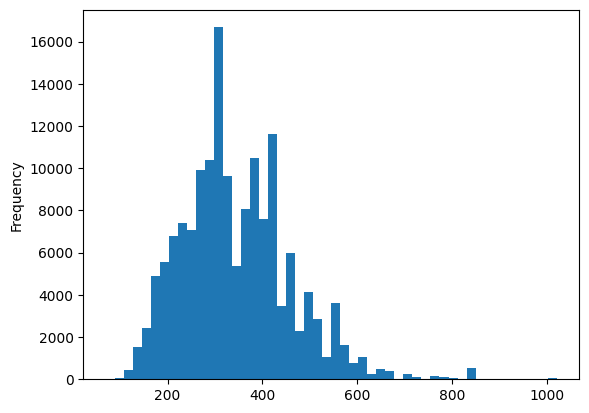

In [ ]:
train["horsepower"].plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

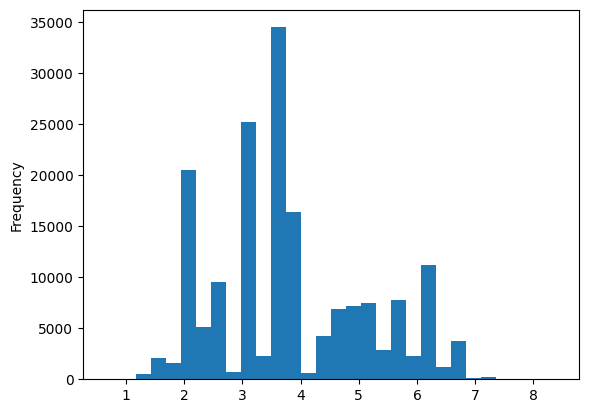

In [ ]:
train["engine_liters"].plot(kind="hist", bins = 30)

In [ ]:
train.loc[train["cylinders"] == 120.0, "cylinders"] = 12.0

,cylinders
0,4.0
1,8.0
2,8.0
3,8.0
4,4.0
...,...
188528,8.0
188529,6.0
188530,8.0
188531,NaN


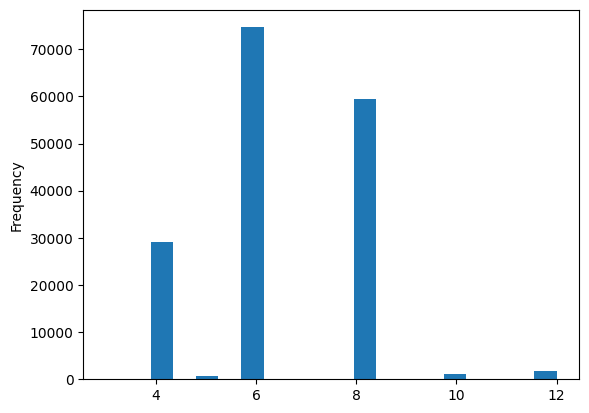

In [ ]:
train["cylinders"].plot(kind="hist", bins = 20)
train["cylinders"]

In [ ]:
hp_median = train["horsepower"].median()
train.loc[train["horsepower"].isna(), "horsepower"] = hp_median

liters_median = train["engine_liters"].median()
train.loc[train["engine_liters"].isna(), "engine_liters"] = liters_median

cylinders_mode = train["cylinders"].mode()
train.loc[train["cylinders"].isna(), "cylinders"] = cylinders_mode[0]

In [ ]:
# do it for test
hp_median = test["horsepower"].median()
test.loc[test["horsepower"].isna(), "horsepower"] = hp_median

liters_median = test["engine_liters"].median()
test.loc[test["engine_liters"].isna(), "engine_liters"] = liters_median

cylinders_mode = test["cylinders"].mode()
test.loc[test["cylinders"].isna(), "cylinders"] = cylinders_mode[0]

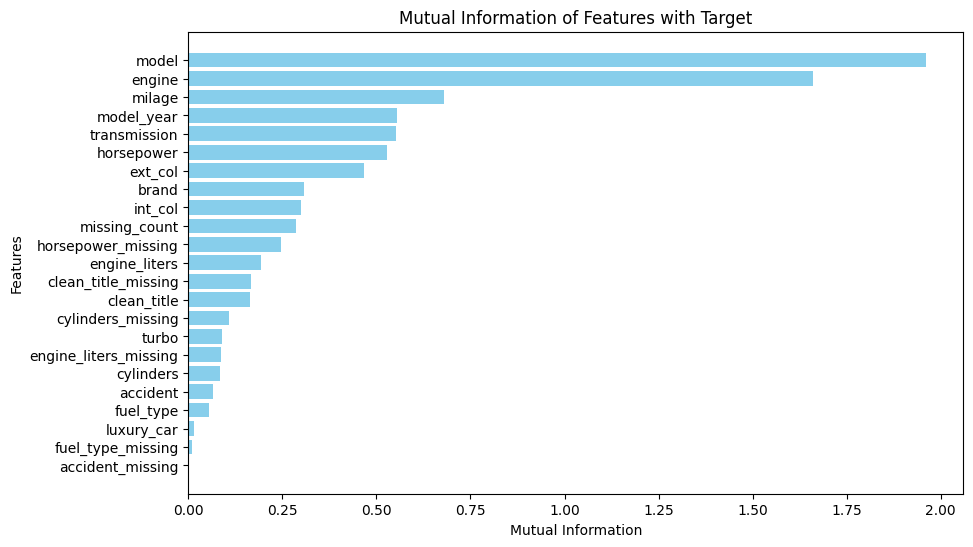

In [ ]:
from sklearn.feature_selection import mutual_info_classif

columns = train.drop("price", axis=1).columns
# Target column
target_column = 'price'

# Sample the data if necessary (optional)
# df_sampled = train.sample(n=10000, random_state=42)  # Uncomment if you want to sample the data
df_sampled = train

# Calculate mutual information
X = df_sampled[columns]
y = df_sampled[target_column]

# Function to calculate mutual information for a single column
def calculate_mi(column):
    if X[column].dtype == 'object':
        X_encoded = X[[column]].apply(lambda col: col.astype('category').cat.codes)
        mi = mutual_info_classif(X_encoded, y, discrete_features=True)
        return mi.sum()
    else:
        mi = mutual_info_classif(X[[column]], y, discrete_features=False)
        return mi[0]

# Calculate mutual information for each column
mi_scores = {col: calculate_mi(col) for col in columns}

# Print the dictionary of mutual information values
mi_df = pd.DataFrame(list(mi_scores.items()), columns=['Feature', 'Mutual Information'])

# Sort the DataFrame by mutual information
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information of Features with Target')
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

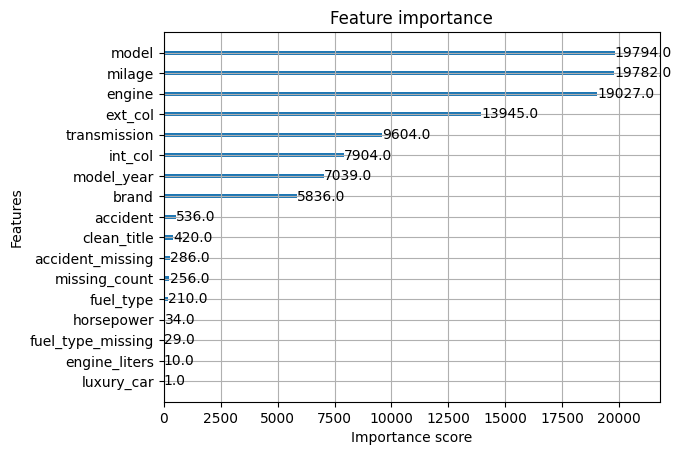

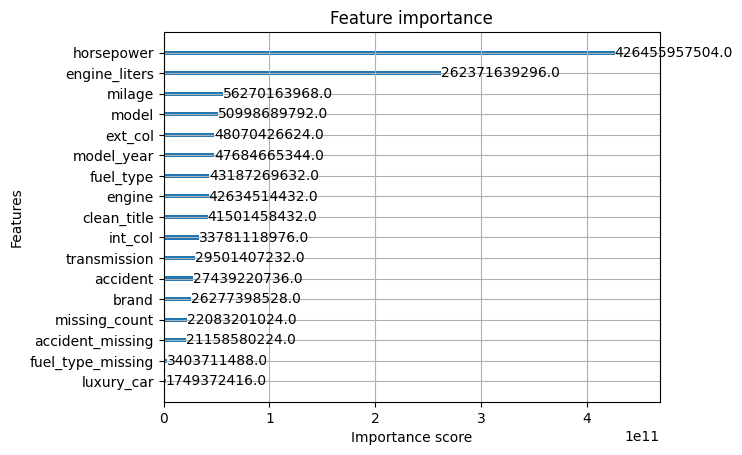

In [ ]:
# get feature importance from xgboost model and plot

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# convert categoricals to train to 'category'

for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category')

X_train, X_val, y_train, y_val = train_test_split(train.drop("price", axis=1), train["price"], test_size=0.2, random_state=42)



xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, enable_categorical=True)

xgb_model.fit(X_train, y_train)

xgb.plot_importance(xgb_model, importance_type="weight")

xgb.plot_importance(xgb_model, importance_type="gain")


In [ ]:
train.drop(["fuel_type_missing", "luxury_car"], axis=1, inplace=True)
test.drop(["fuel_type_missing", "luxury_car"], axis=1, inplace=True)

In [ ]:
train.nunique()

,0
brand,57
model,1897
model_year,34
milage,6651
fuel_type,9
engine,1117
transmission,52
ext_col,319
int_col,156
accident,2


In [ ]:
X_trainval, y_trainval = train.drop("price", axis=1), train["price"]
X_test = test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder
tg_cols = ["brand", "model", "engine", "transmission", "ext_col", "int_col"]

te = TargetEncoder(cols=tg_cols)

tg_df = te.fit_transform(X_train[tg_cols], y_train)
X_train[tg_cols] = tg_df

tg_df = te.fit_transform(X_val[tg_cols], y_val)
X_val[tg_cols] = tg_df

tg_df = te.fit_transform(X_trainval[tg_cols], y_trainval)
X_trainval[tg_cols] = tg_df

tg_df = te.transform(X_test[tg_cols])
X_test[tg_cols] = tg_df

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

num_cols = ["model_year", "milage", "horsepower", "engine_liters", "cylinders", "missing_count","brand", "model", "engine", "transmission", "ext_col", "int_col"]

ohe_cols = ["fuel_type"]

ord_cols = ["accident", "clean_title", "accident_missing", "clean_title_missing", "turbo", "horsepower_missing", "engine_liters_missing", "cylinders_missing"]
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

ohe_pipeline = Pipeline([
    ('ohe', OneHotEncoder())
])


ord_pipeline = Pipeline([
    ('ord_enc', OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('ohe', ohe_pipeline, ohe_cols),
    ('ord', ord_pipeline, ord_cols)
])

In [ ]:
X_train_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

X_val_proc = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())

X_trainval_proc = pd.DataFrame(preprocessor.fit_transform(X_trainval), columns=preprocessor.get_feature_names_out())

X_test_proc = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [ ]:
len(X_train_proc), len(X_val_proc), len(X_trainval_proc)

(150826, 37707, 188533)

# 4. Modelling and Hyperparameter Tuning

In [ ]:
import optuna
import xgboost as xgb

dX_train = xgb.DMatrix(data=X_train_proc, label=y_train, enable_categorical=True)
dX_val = xgb.DMatrix(data=X_val_proc, label=y_val, enable_categorical=True)
dX_trainval = xgb.DMatrix(data=X_trainval_proc, label=y_trainval, enable_categorical=True)
dX_test = xgb.DMatrix(data=X_test_proc, enable_categorical=True)






In [ ]:
metric = 'rmse'

base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
}

In [ ]:
from sklearn.metrics import mean_squared_error

def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label()
    y_pred = model.predict(dmat)
    return mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
import time
learning_rate = 0.3

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}

params.update(base_params)
tic = time.time()
model = xgb.train(params=params, dtrain=dX_train,
                  evals=[(dX_train, 'train'), (dX_val, 'valid')],
                  num_boost_round=10000,
                  early_stopping_rounds=50,
                  verbose_eval=0)
print(f"{time.time() - tic:.1f} seconds")

2.2 seconds


In [ ]:
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"valid-{metric}")

    model = xgb.train(params=params, dtrain=dX_train, num_boost_round=num_boost_round,
    evals=[(dX_train, 'train'), (dX_val, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=0,
    callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score


In [ ]:
!pip install optuna-integration[xgboost]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-09-11 13:14:46,626] A new study created in memory with name: no-name-f5fde2bd-3ce1-42c0-b6ea-b6b1ba77be41
[I 2025-09-11 13:14:51,691] Trial 0 finished with value: 67314.35679299841 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 88, 'subsample': 0.9188213924322277, 'colsample_bynode': 0.9035803085277028, 'reg_lambda': 5.394894965081852}. Best is trial 0 with value: 67314.35679299841.
[I 2025-09-11 13:14:54,173] Trial 1 finished with value: 67413.21085305636 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'min_child_weight': 61, 'subsample': 0.3035142435312254, 'colsample_bynode': 0.1707449241428437, 'reg_lambda': 0.0576401357218285}. Best is trial 0 with value: 67314.35679299841.
[I 2025-09-11 13:14:55,969] Trial 2 finished with value: 67775.42550884692 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'min_child_weight': 16, 'subsample': 0.1673058841345243, 'colsample_bynode': 0.19551048486129102, 'reg_lambda': 13.88140515809145

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-09-11 13:17:23,294] A new study created in memory with name: no-name-12bc8376-64db-4a1e-9d83-5a2c3a84adda
[I 2025-09-11 13:17:25,002] Trial 0 finished with value: 67370.98369842453 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 67370.98369842453.
[I 2025-09-11 13:17:28,212] Trial 1 finished with value: 68792.38304685116 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 0 with value: 67370.98369842453.
[I 2025-09-11 13:17:29,537] Trial 2 finished with value: 67177.55042023702 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.4907861801

In [ ]:
low_eta = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_eta
model_stage2 = xgb.train(params=params,
                        dtrain=dX_train,
                        num_boost_round=10000,
                        evals=[(dX_train, 'train'),(dX_val, 'valid')],
                        early_stopping_rounds=50,
                        verbose_eval=0)

In [ ]:
xgb_boost_rounds = model_stage2.best_iteration
xgb_best_params = params
xgb_boost_rounds

1184

best xgb params

{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'tree_method': 'hist',
 'max_depth': 10,
 'min_child_weight': 250,
 'subsample': 0.8798706803142061,
 'colsample_bynode': 0.4710525279337534,
 'reg_lambda': 0.010149060427718995,
 'learning_rate': 0.01}

 xgb_boost_rounds = 538

In [ ]:
metric = 'RMSE'

base_params = {
    'loss_function': metric
}

In [ ]:
from catboost import CatBoostRegressor, Pool
import time

train_pool = Pool(data=X_train_proc, label=y_train)
eval_pool = Pool(data=X_val_proc, label=y_val)

eta = 0.3

params = {
    'learning_rate': eta
}

params.update(base_params)
cat_model = CatBoostRegressor(**params, iterations=10000, use_best_model=True, od_type='Iter', od_wait=50)
tic = time.time()
cat_model.fit(train_pool, eval_set=eval_pool)
t_delta = time.time() - tic

print(t_delta)

0:	learn: 77112.4592864	test: 71770.4050175	best: 71770.4050175 (0)	total: 77.1ms	remaining: 12m 51s
1:	learn: 75420.1162031	test: 70136.8542447	best: 70136.8542447 (1)	total: 102ms	remaining: 8m 30s
2:	learn: 74494.7886039	test: 69038.8106039	best: 69038.8106039 (2)	total: 129ms	remaining: 7m 8s
3:	learn: 73921.6557869	test: 68483.4759486	best: 68483.4759486 (3)	total: 152ms	remaining: 6m 20s
4:	learn: 73501.3112482	test: 68138.5902689	best: 68138.5902689 (4)	total: 175ms	remaining: 5m 50s
5:	learn: 73261.7707924	test: 67962.0808006	best: 67962.0808006 (5)	total: 198ms	remaining: 5m 30s
6:	learn: 73046.4010905	test: 67780.4717509	best: 67780.4717509 (6)	total: 220ms	remaining: 5m 13s
7:	learn: 72884.5419428	test: 67684.7142907	best: 67684.7142907 (7)	total: 244ms	remaining: 5m 4s
8:	learn: 72690.6598976	test: 67602.8388919	best: 67602.8388919 (8)	total: 267ms	remaining: 4m 55s
9:	learn: 72552.6423532	test: 67563.8404589	best: 67563.8404589 (9)	total: 292ms	remaining: 4m 51s
10:	learn:

In [ ]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": 0.3,
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }




    model = cb.CatBoostRegressor(**params, silent=True, use_best_model=True, od_type='Iter', od_wait=50)
    model.fit(train_pool, eval_set=eval_pool)
    predictions = model.predict(X_val_proc)
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:

study = optuna.create_study(direction='minimize')

tic = time.time()

while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-09-11 13:28:05,450] A new study created in memory with name: no-name-9957ac56-9967-43d4-b8d6-eb2d49a5ec45
[I 2025-09-11 13:28:08,304] Trial 0 finished with value: 66952.9410955963 and parameters: {'depth': 4, 'subsample': 0.6592207933239584, 'colsample_bylevel': 0.16615338143745645, 'min_data_in_leaf': 99}. Best is trial 0 with value: 66952.9410955963.
[I 2025-09-11 13:28:10,686] Trial 1 finished with value: 67404.23119868376 and parameters: {'depth': 10, 'subsample': 0.20680775393579454, 'colsample_bylevel': 0.14148818425379178, 'min_data_in_leaf': 8}. Best is trial 0 with value: 66952.9410955963.
[I 2025-09-11 13:28:12,473] Trial 2 finished with value: 67254.59855025579 and parameters: {'depth': 4, 'subsample': 0.7104859193531233, 'colsample_bylevel': 0.519959508818906, 'min_data_in_leaf': 59}. Best is trial 0 with value: 66952.9410955963.
[I 2025-09-11 13:28:17,032] Trial 3 finished with value: 67142.75138714042 and parameters: {'depth': 9, 'subsample': 0.7358317185698697, '

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
optimal_params = study.best_params
optimal_params["learning_rate"] = 0.01
cat_model = CatBoostRegressor(**optimal_params, iterations=10000, use_best_model=True, od_type='Iter', od_wait=50)
cat_model.fit(train_pool, eval_set=eval_pool)

0:	learn: 79741.9427710	test: 74465.1292255	best: 74465.1292255 (0)	total: 22.1ms	remaining: 3m 41s
1:	learn: 79641.3266909	test: 74358.3615634	best: 74358.3615634 (1)	total: 41.3ms	remaining: 3m 26s
2:	learn: 79542.6280763	test: 74247.4890438	best: 74247.4890438 (2)	total: 59.7ms	remaining: 3m 18s
3:	learn: 79440.2467043	test: 74151.4175022	best: 74151.4175022 (3)	total: 78.1ms	remaining: 3m 15s
4:	learn: 79341.3172222	test: 74053.5620345	best: 74053.5620345 (4)	total: 96.5ms	remaining: 3m 12s
5:	learn: 79246.7717607	test: 73960.2367271	best: 73960.2367271 (5)	total: 136ms	remaining: 3m 46s
6:	learn: 79149.3017399	test: 73866.5954819	best: 73866.5954819 (6)	total: 155ms	remaining: 3m 41s
7:	learn: 79053.6921096	test: 73770.7534602	best: 73770.7534602 (7)	total: 174ms	remaining: 3m 37s
8:	learn: 78959.6597270	test: 73679.8412505	best: 73679.8412505 (8)	total: 194ms	remaining: 3m 35s
9:	learn: 78867.3855400	test: 73591.5662992	best: 73591.5662992 (9)	total: 212ms	remaining: 3m 32s
10:	l

In [ ]:
optimal_params

{'depth': 5,
 'subsample': 0.6052062223451852,
 'colsample_bylevel': 0.7726470214500782,
 'min_data_in_leaf': 75,
 'learning_rate': 0.01}

best catboost params:

{'depth': 4,
 'subsample': 0.9629275021934809,
 'colsample_bylevel': 0.3719662939757698,
 'min_data_in_leaf': 46,
 'learning_rate': 0.01}

 best iters = 2038

In [ ]:
from xgboost import XGBRegressor

xgb_final = XGBRegressor(**xgb_best_params, n_estimators=xgb_boost_rounds)

xgb_final.fit(X_train_proc, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.2797064039425238,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=115, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1184,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_final.predict(X_val_proc)

print(mean_squared_error(y_val, y_pred))

4475462144.0


In [ ]:
xgb_best_params = {'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'tree_method': 'hist',
 'max_depth': 10,
 'min_child_weight': 250,
 'subsample': 0.8798706803142061,
 'colsample_bynode': 0.4710525279337534,
 'reg_lambda': 0.010149060427718995,
 'learning_rate': 0.01,
 'n_estimators': 538}


cat_best_params = {'depth': 4,
 'subsample': 0.9629275021934809,
 'colsample_bylevel': 0.3719662939757698,
 'min_data_in_leaf': 46,
 'learning_rate': 0.01,
 'iterations': 2038}

In [ ]:
xgb_test = XGBRegressor(**xgb_best_params)
xgb_test.fit(X_trainval_proc, y_trainval)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.4710525279337534,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=250, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=538,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
cat_test = CatBoostRegressor(**cat_best_params)
cat_test.fit(X_trainval_proc, y_trainval)

0:	learn: 78725.4677880	total: 28.1ms	remaining: 57.3s
1:	learn: 78639.3454164	total: 50.1ms	remaining: 51s
2:	learn: 78542.2811799	total: 72.3ms	remaining: 49.1s
3:	learn: 78471.3274167	total: 92.4ms	remaining: 47s
4:	learn: 78388.9064301	total: 114ms	remaining: 46.2s
5:	learn: 78296.8765642	total: 134ms	remaining: 45.3s
6:	learn: 78202.1389293	total: 155ms	remaining: 45s
7:	learn: 78111.7360376	total: 176ms	remaining: 44.6s
8:	learn: 78029.6251434	total: 195ms	remaining: 44s
9:	learn: 77969.0492964	total: 215ms	remaining: 43.6s
10:	learn: 77886.3654562	total: 241ms	remaining: 44.4s
11:	learn: 77803.5051624	total: 263ms	remaining: 44.3s
12:	learn: 77729.0887533	total: 285ms	remaining: 44.4s
13:	learn: 77654.2306002	total: 308ms	remaining: 44.5s
14:	learn: 77579.4318799	total: 328ms	remaining: 44.3s
15:	learn: 77498.3696826	total: 350ms	remaining: 44.3s
16:	learn: 77430.7169589	total: 371ms	remaining: 44.1s
17:	learn: 77353.9877574	total: 391ms	remaining: 43.9s
18:	learn: 77279.1052218

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


st = StackingRegressor([
    ('xgb', XGBRegressor(**xgb_best_params)),
    ('cat', CatBoostRegressor(**cat_best_params))
], final_estimator=LinearRegression(), n_jobs=-1)

st.fit(X_trainval_proc, y_trainval)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=0.4710525279337534,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            int...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=250, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=538, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7bc6e9e22360>)],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [ ]:
sub_preds = st.predict(X_test_proc)

In [ ]:
id_col = pd.read_csv('/content/test.csv')["id"].values

sub_file = pd.DataFrame({
    'id': id_col,
    'price': sub_preds
})

sub_file

,id,price
0,188533,16660.620584
1,188534,83568.610375
2,188535,52356.727631
3,188536,30205.032954
4,188537,28723.735971
...,...,...
125685,314218,28038.505282
125686,314219,52646.704612
125687,314220,21220.952475
125688,314221,16248.984303


In [ ]:
sub_file.to_csv("submission.csv", index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>